# Demo of API usage of the Prox Soft Body Simulator

In [17]:
%matplotlib widget

First we make sure to import all modules that is needed.

In [18]:
import numpy as np
import isl.math.vector3 as V3
import isl.geometry.volume_mesh as VM
import isl.simulators.prox_soft_bodies.api as API
import isl.simulators.prox_soft_bodies.solver as SOLVER
import isl.util.viewer as VIEWER

Second we set up a test scene using a simple beam shape. The beam is created with Dirichlet constraints on its left-most face. We let gravity work on the beam and add some slight damping to the beam as well. The end result should be a beam simulation where we will see the right-most end of the beam bounce up and down.

In [21]:
def left_wall(x):
    return x[0] + 1.9

def right_wall(x):
    return 1.9- x[0]

V, T = VM.create_beam(11, 3, 3, 4.0, 1.0, 1.0)

engine = API.Engine()

API.create_soft_body(engine, 'beam', V, T)
API.set_type(engine, 'beam', 'Free')
API.create_dirichlet_conditions(engine, 'beam', left_wall)
API.create_traction_conditions(engine, 'beam', right_wall, load=V3.make(-10,-200,0))
API.create_material(engine, 'steel')
API.set_elasticity(engine, 'steel', 100000.0, 0.3)
API.set_mass_density(engine, 'steel', 500.0)
API.set_constitutive_model(engine, 'steel', API.SVK)
API.set_viscosity(engine, 'steel', 0.5)
API.create_surfaces_interaction(engine,'steel','steel', 0.5)
API.set_gravity(engine, 'beam', (0,-1,0))
API.set_material(engine,'beam','steel')

Next we create a viewer object that will be responsible for showing the animation. We need an auxiliary function that can take contact point data out of the engine and into the viewer.

Once we got this in place then we can create a simulation loop and start the simulation.

In [ ]:
print('Color explanation')
print('\tFEM Mesh: Red')
print('\tTraction Surface: Blue')
print('\tDirchlet Nodes: Black')
print('\tElastic Forces: Green')
print('\tExternal Forces: Purple')
print('\tDamping Forces: Gray')
print('\tTraction Forces: Yellow')


viewer = VIEWER.Viewer()
viewer.create_frame("origin")

#viewer.create_quiver('contacts')
for body in engine.bodies.values():
    FTi = [ tc.i for tc in body.traction_conditions ]
    FTj = [ tc.j for tc in body.traction_conditions ]
    FTk = [ tc.k for tc in body.traction_conditions ]
    FT = np.array([FTi, FTj, FTk]).T
    DC = [ dc.idx for dc in body.dirichlet_conditions ]
    
    opacity = 0.5
    color = V3.make(1.0,0.1,0.1)
    F = VM.to_triangles(body.T)
    viewer.create_mesh(body.name, body.x0, F, color, opacity)    
    viewer.create_quiver(body.name + '.Fe')
    viewer.create_quiver(body.name + '.Fext')
    viewer.create_quiver(body.name + '.Fd')
    viewer.create_quiver(body.name + '.Ft')
    viewer.create_scatter(body.name + '.DBC')    
    opacity = 1.0
    color = V3.make(0.1,0.1,1.0)
    viewer.create_mesh(body.name+"traction", body.x0, FT, color, opacity)    

def update_contacts(viewer, engine): 
    K = len(engine.contact_points)
    V = np.zeros((K,3),dtype=np.float64)
    N = np.zeros((K,3),dtype=np.float64)
    for k in range(K):
        V[k,:] = engine.contact_points[k].p
        N[k,:] = engine.contact_points[k].n
    viewer.update_quiver('contacts', V, N, 2.0)

    
def simulation(viewer, engine, monitor=True):
    stats = []
    import time
    dt = engine.params.time_step
    T  = engine.params.total_time
    fps = 1.0/dt
    steps = int(np.round(T*fps))    
    for i in range(steps):
        data = SOLVER.stepper(dt, engine, monitor)
        stats.append(data)
    return stats
        
engine.params.total_time = 0.5
engine.params.time_step = 0.001
stats = simulation(viewer, engine, True)

for body in engine.bodies.values():
    viewer.update_mesh(body.name, body.x)
    viewer.update_mesh(body.name+"traction", body.x)
    if body.Fe is not None:
        viewer.update_quiver(body.name + '.Fe', V=body.x, N=body.Fe, scale=0.0001, color=[0.1, 0.7, 0.1])
    if body.Fext is not None:
        viewer.update_quiver(body.name + '.Fext', V=body.x, N=body.Fext, scale=0.0001, color=[0.7, 0.1, 0.7])
    if body.Fd is not None:
        viewer.update_quiver(body.name + '.Fd', V=body.x, N=body.Fd, scale=0.1, color=[0.7, 0.7, 0.7])
    if body.Ft is not None:
        viewer.update_quiver(body.name + '.Ft', V=body.x, N=body.Ft, scale=0.01, color=[0.7, 0.7, 0.1])            
    if len(body.dirichlet_conditions)>0:
        indices = [bc.idx for bc in body.dirichlet_conditions]
        V = body.x[indices]
        viewer.update_scatter(body.name + '.DBC', V=V, scale=0.5, color=[0.4, 0.4, 0.4])                                            
    #update_contacts(viewer, engine)
viewer.show()
#viewer.hide_quiver('contacts')


Color explanation
	FEM Mesh: Red
	Traction Surface: Blue
	Dirchlet Nodes: Black
	Elastic Forces: Green
	External Forces: Purple
	Damping Forces: Gray
	Traction Forces: Yellow


The stepper function in the SOLVER module is the main work horse of the simulation. It outputs a lot of statistics about the numerics. This data is useful to analyze what happend in the simulation and if the simulator was working or if something unexpected happend.

Often one cares about the convergence of the solver. It is not difficult to extract and plot the convergence rates.

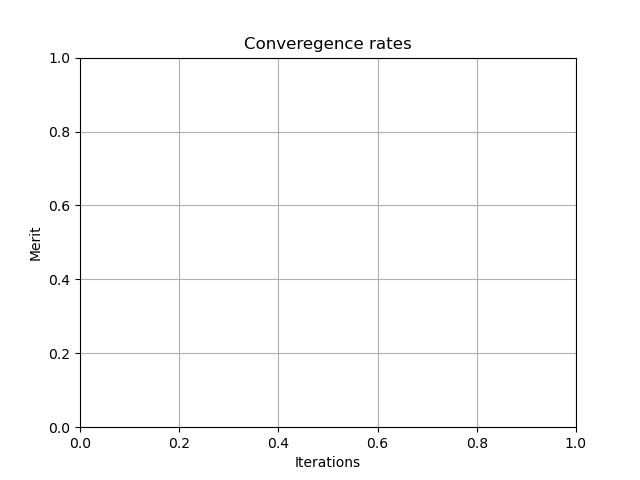

In [5]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.subplot(111)
ax.set_title('Converegence rates')
ax.set_xlabel('Iterations')
ax.set_ylabel('Merit')
plt.grid(True)
for i in range(len(stats)):
    data = stats[i]
    if 'residuals' in data.keys():
        residuals = data['residuals']
        reject = data['reject']
        ax.plot( residuals[np.where(reject==False)])
plt.show()

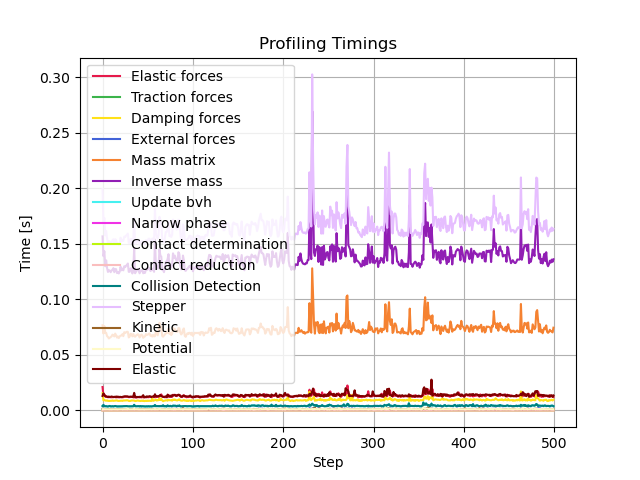

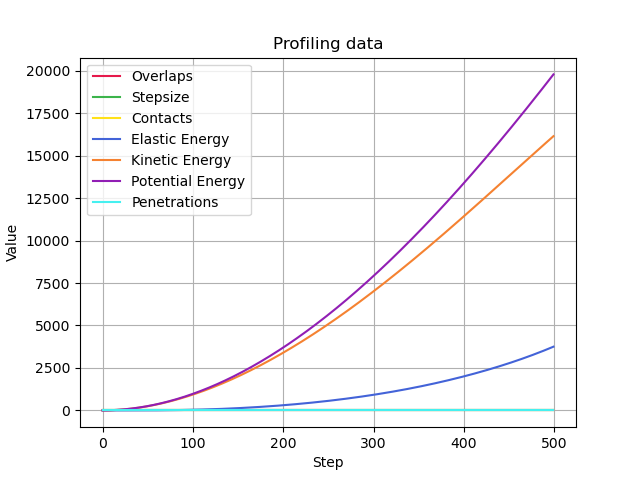

In [9]:
colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4',
          '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff',
          '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1',
          '#000075', '#808080', '#ffffff', '#000000']


time_elastic_forces = [ stats[i]['compute_elastic_forces'] for i in range(len(stats)) ]
time_traction_forces = [ stats[i]['compute_traction_forces'] for i in range(len(stats)) ]
time_damping_forces = [ stats[i]['compute_damping_forces'] for i in range(len(stats)) ]
time_external_forces = [ stats[i]['compute_external_forces'] for i in range(len(stats)) ]
time_mass_matrix = [ stats[i]['compute_mass_matrix'] for i in range(len(stats)) ]
time_inverse_mass_matrix = [ stats[i]['compute_inverse_mass_matrix'] for i in range(len(stats)) ]
time_update_bvh = [ stats[i]['update_bvh'] for i in range(len(stats)) ]
time_narrow_phase = [ stats[i]['narrow_phase'] for i in range(len(stats)) ]
time_contact_determination = [ stats[i]['contact_determination'] for i in range(len(stats)) ]
time_contact_point_reduction = [ stats[i]['contact_point_reduction'] for i in range(len(stats)) ]
time_collision_detection = [ stats[i]['collision_detection_time'] for i in range(len(stats)) ]
time_stepper = [ stats[i]['stepper_time'] for i in range(len(stats)) ]
time_kinetic_energy = [ stats[i]['compute_kinetic_energy'] for i in range(len(stats)) ]
time_poential_energy = [ stats[i]['compute_potential_energy'] for i in range(len(stats)) ]
time_elastic_energy = [ stats[i]['compute_elastic_energy'] for i in range(len(stats)) ]

fig = plt.figure()
ax = plt.subplot(111)
ax.set_title('Profiling Timings')
ax.set_xlabel('Step')
ax.set_ylabel('Time [s]')
plt.grid(True)
ax.plot(time_elastic_forces, label='Elastic forces', color=colors[0])
ax.plot(time_traction_forces, label='Traction forces', color=colors[1])
ax.plot(time_damping_forces, label='Damping forces', color=colors[2])
ax.plot(time_external_forces, label='External forces', color=colors[3])
ax.plot(time_mass_matrix, label='Mass matrix', color=colors[4])
ax.plot(time_inverse_mass_matrix, label='Inverse mass', color=colors[5])
ax.plot(time_update_bvh, label='Update bvh', color=colors[6])
ax.plot(time_narrow_phase, label='Narrow phase', color=colors[7])
ax.plot(time_contact_determination, label='Contact determination', color=colors[8])
ax.plot(time_contact_point_reduction, label='Contact reduction', color=colors[9])
ax.plot(time_collision_detection, label='Collision Detection', color=colors[10])
ax.plot(time_stepper, label='Stepper', color=colors[11])
ax.plot(time_kinetic_energy, label='Kinetic', color=colors[12])
ax.plot(time_poential_energy, label='Potential', color=colors[13])
ax.plot(time_elastic_energy, label='Elastic', color=colors[14])
ax.legend()
plt.show()

number_of_overlaps = [ stats[i]['number_of_overlaps'] for i in range(len(stats)) ]
step_sizes = [ stats[i]['dt'] for i in range(len(stats)) ]
number_of_contact_points = [ stats[i]['contact_points'] for i in range(len(stats)) ]
elastic_energy = [ stats[i]['elastic_energy'] for i in range(len(stats)) ]
kinetic_energy = [ stats[i]['kinetic_energy'] for i in range(len(stats)) ]
potential_energy = [ stats[i]['potential_energy'] for i in range(len(stats)) ]
penetrations = [ stats[i]['max_penetration'] for i in range(len(stats)) ]

fig = plt.figure()
ax = plt.subplot(111)
ax.set_title('Profiling data')
ax.set_xlabel('Step')
ax.set_ylabel('Value')
plt.grid(True)
ax.plot(number_of_overlaps, label='Overlaps', color=colors[0])
ax.plot(step_sizes, label='Stepsize', color=colors[1])
ax.plot(number_of_contact_points, label='Contacts', color=colors[2])
ax.plot(elastic_energy, label='Elastic Energy', color=colors[3])
ax.plot(kinetic_energy, label='Kinetic Energy', color=colors[4])
ax.plot(potential_energy, label='Potential Energy', color=colors[5])
ax.plot(penetrations, label='Penetrations', color=colors[6])
ax.legend()
plt.show()



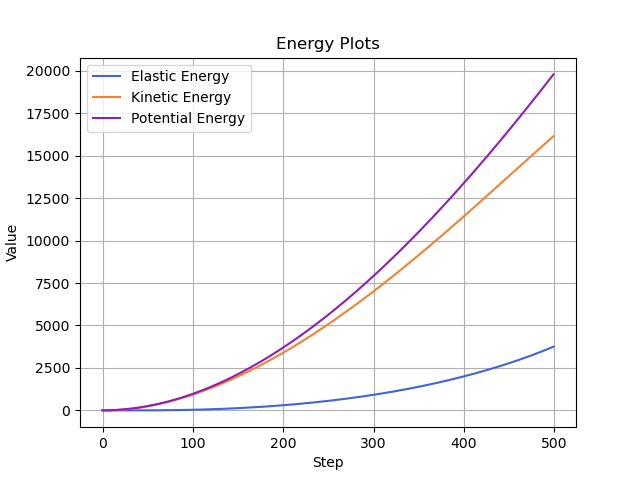

In [10]:
fig = plt.figure()
ax = plt.subplot(111)
ax.set_title('Energy Plots')
ax.set_xlabel('Step')
ax.set_ylabel('Value')
plt.grid(True)
ax.plot(elastic_energy, label='Elastic Energy', color=colors[3])
ax.plot(kinetic_energy, label='Kinetic Energy', color=colors[4])
ax.plot(potential_energy, label='Potential Energy', color=colors[5])
ax.legend()
plt.show()